# Construir uma árvore de decisão de classificação

Vamos ilustrar como a árvore de decisão ajusta os dados com uma classificação simples
problema ao usar o conjunto de dados de pinguins.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

In [1]:
import pandas as pd

penguins = pd.read_csv("penguins_classification.csv")

culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

In [2]:
penguins.head(3)

,Culmen Length (mm),Culmen Depth (mm),Species
0,39.1,18.7,Adelie
1,39.5,17.4,Adelie
2,40.3,18.0,Adelie


In [25]:
penguins['Species'].value_counts()

Adelie       151
Gentoo       123
Chinstrap     68
Name: Species, dtype: int64

Além disso, dividimos os dados em dois subconjuntos para investigar como as árvores
prever valores com base em um conjunto de dados fora das amostras.

In [3]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)
range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns}

Em um notebook anterior, aprendemos que um classificador linear irá definir um
separação linear para dividir classes usando uma combinação linear da entrada
recursos. Em nosso espaço bidimensional, isso significa que um classificador linear irá
definir algumas linhas oblíquas que melhor separam nossas classes. Nós definimos um
função abaixo disso, dado um conjunto de pontos de dados e um classificador, irá traçar
os limites de decisão aprendidos pelo classificador.

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

Assim, para um classificador linear, obteremos a seguinte decisão
limites. Essas linhas de limites indicam onde o modelo muda seu
previsão de uma aula para outra.

In [5]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(data_train, target_train)

LogisticRegression()

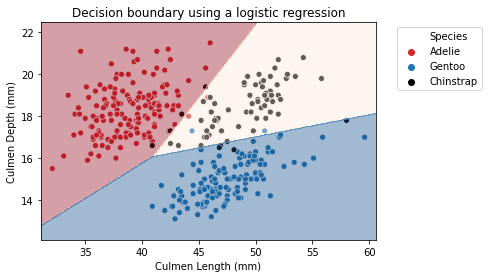

In [6]:
import seaborn as sns

# create a palette to be used in the scatterplot
palette = ["tab:red", "tab:blue", "black"]

ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                     hue=target_column, palette=palette)
plot_decision_function(linear_model, range_features, ax=ax)
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a logistic regression")

Vemos que as linhas são uma combinação dos recursos de entrada, uma vez que são
não perpendicular a um eixo específico. Na verdade, isso se deve ao modelo
parametrização que vimos no notebook anterior, controlada pelo
pesos e interceptações do modelo.

Além disso, parece que o modelo linear seria um bom candidato para
problema, pois dá uma boa precisão.

In [7]:
linear_model.fit(data_train, target_train)
test_score = linear_model.score(data_test, target_test)
print(f"Accuracy of the LogisticRegression: {test_score:.2f}")

Accuracy of the LogisticRegression: 0.98


Ao contrário dos modelos lineares, as árvores de decisão são modelos não paramétricos: eles não são
controlados por uma função de decisão matemática e não têm pesos ou
interceptar para ser otimizado.

Na verdade, as árvores de decisão dividirão o espaço considerando um único
recurso de cada vez. Vamos ilustrar esse comportamento tomando uma decisão
árvore faz uma única divisão para particionar o espaço de recursos.

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=1)

As partições encontradas pelo algoritmo separam os dados ao longo do eixo
"Culmen Depth", descartando o recurso "Culmen Length". Assim, destaca
que uma árvore de decisão não usa uma combinação de recursos ao fazer um
dividir. Podemos examinar mais a fundo a estrutura da árvore.

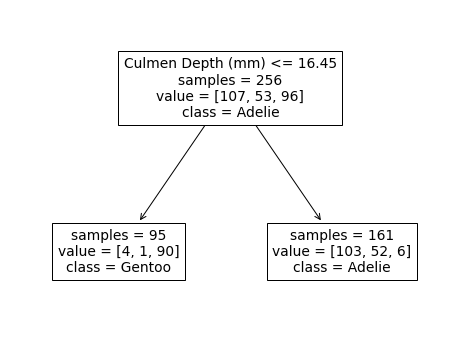

In [9]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">Estamos usando a função <tt class="docutils literal">fig, ax = <span class="pre">plt.subplots(figsize=(8,</span> 6))</tt> para criar uma figura e um eixo com tamanho específico. Então, podemos passar o eixo para o
<tt class="docutils literal">sklearn.tree.plot_tree</tt> função para que o desenho aconteça neste eixo. </p>
</div>

Vemos que a divisão foi feita pelo recurso de profundidade do cúlmen. O original
conjunto de dados foi subdividido em 2 conjuntos com base na profundidade do cúlmen
(inferior ou superior a 16,45 mm).

Esta partição do conjunto de dados minimiza as diversidades de classes em cada
sub-partições. Essa medida também é conhecida como **critério**,
e é um parâmetro configurável.

Se olharmos mais de perto para a partição, vemos que a amostra superior a
16,45 pertence principalmente à classe Adelie. Olhando para os valores, nós de fato
observe 103 indivíduos Adelie neste espaço. Também contamos 52 Chinstrap
amostras e 6 amostras do Gentoo. Podemos fazer uma interpretação semelhante para o
partição definida por um limite inferior a 16,45 mm. Neste caso, a maioria
classe representada é a espécie Gentoo.

Vamos ver como nossa árvore funcionaria como um preditor. Vamos começar a ver o
classe prevista quando a profundidade do cúlmen é inferior ao limiar.

In [10]:
tree.predict([[0, 15]])

array(['Gentoo'], dtype=object)

A classe prevista é o Gentoo. Agora podemos verificar se passamos por um culmen
profundidade superior ao limite.

Nesse caso, a árvore prediz a espécie Adelie.

Assim, podemos concluir que um classificador de árvore de decisão irá prever a maioria
classe representada dentro de uma partição.

Durante o treinamento, temos uma contagem de amostras em cada partição, podemos
também calcula a probabilidade de pertencer a uma classe específica dentro deste
partição.

In [11]:
y_pred_proba = tree.predict_proba([[0, 17]])
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)

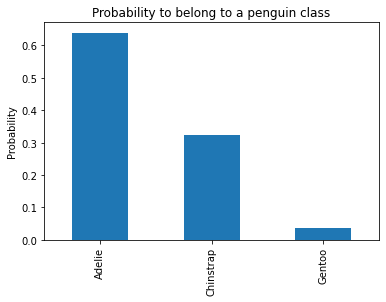

In [12]:
y_proba_class_0.plot.bar()
plt.ylabel("Probability")
_ = plt.title("Probability to belong to a penguin class")

Vamos calcular manualmente as diferentes probabilidades diretamente da árvore
estrutura.

In [13]:
adelie_proba = 103 / 161
chinstrap_proba = 52 / 161
gentoo_proba = 6 / 161
print(f"Probabilities for the different classes:\n"
      f"Adelie: {adelie_proba:.3f}\n"
      f"Chinstrap: {chinstrap_proba:.3f}\n"
      f"Gentoo: {gentoo_proba:.3f}\n")

Probabilities for the different classes:
Adelie: 0.640
Chinstrap: 0.323
Gentoo: 0.037



Também é importante notar que o comprimento do colmo foi desconsiderado para
o momento. Isso significa que qualquer que seja o valor fornecido, ele não será usado
durante a previsão.

In [14]:
tree.predict_proba([[10000, 17]])

array([[0.63975155, 0.32298137, 0.03726708]])

Voltando ao nosso problema de classificação, a divisão encontrada com um máximo
profundidade de 1 não é poderosa o suficiente para separar as três espécies e o modelo
a precisão é baixa quando comparada ao modelo linear.

In [15]:
tree.fit(data_train, target_train)
test_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.78


Na verdade, não é uma surpresa. Vimos anteriormente que um único recurso não
ser capaz de separar as três espécies. No entanto, a partir da análise anterior, nós
vi que, usando os dois recursos, poderíamos obter resultados bastante bons.

No próximo exercício, você aumentará o tamanho da profundidade da árvore. Você irá
obtenha intuições de como o particionamento do espaço se repete ao longo do tempo.

# 📝 Exercício M5.01

No caderno anterior, mostramos como uma árvore com profundidade de 1 nível era
trabalhando. O objetivo deste exercício é repetir parte do anterior
experimente uma profundidade com 2 níveis para mostrar como o processo de particionamento
é repetido ao longo do tempo.

Antes de começar, vamos:

* carregue o conjunto de dados;
* dividir o conjunto de dados em conjunto de dados de treinamento e teste;
* definir a função para mostrar a função de decisão de classificação.

In [17]:
import pandas as pd

penguins = pd.read_csv("penguins_classification.csv")

culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

In [29]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)
range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns
}

In [20]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

Crie um classificador de árvore de decisão com uma profundidade máxima de 2 níveis e ajuste
os dados de treinamento. Uma vez que este classificador seja treinado, plote os dados e o
limite de decisão para ver o benefício de aumentar a profundidade.

In [35]:
# solution
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=2)

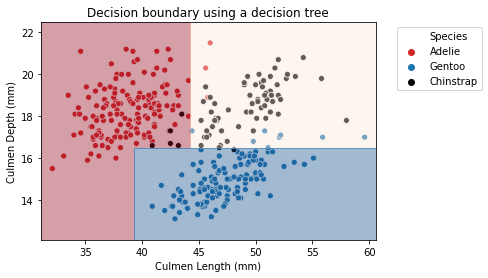

In [36]:
import seaborn as sns

palette = ["tab:red", "tab:blue", "black"]
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                     hue=target_column, palette=palette)
plot_decision_function(tree, range_features, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a decision tree")

Utilizamos o recurso "Comprimento Culmen"?
Plote a árvore usando a função `sklearn.tree.plot_tree` para descobrir!

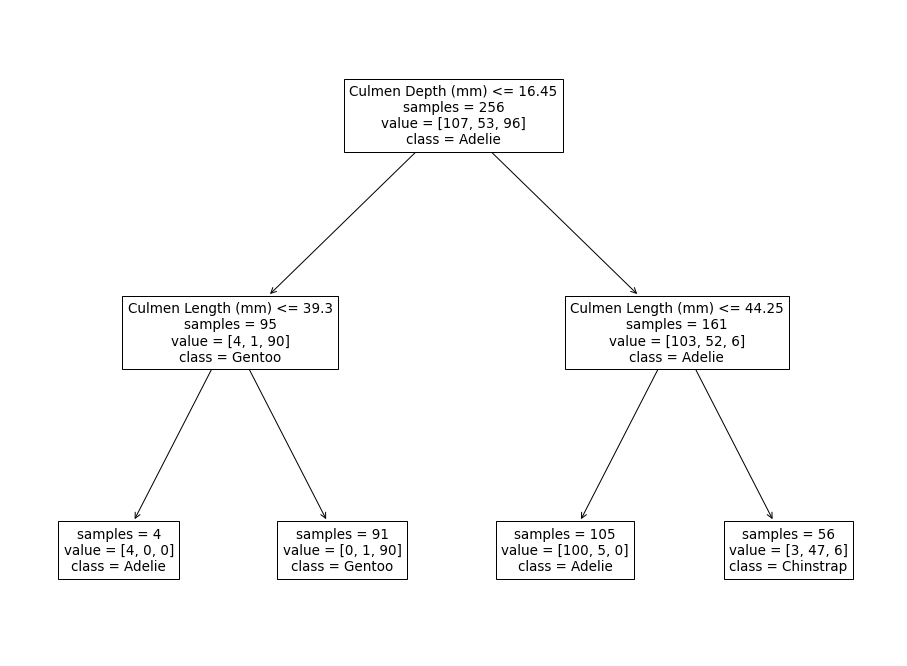

In [37]:
# solution
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(16, 12))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

Calcule a precisão da árvore de decisão nos dados de teste.

In [39]:
# solution
test_score = tree.fit(data_train, target_train).score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.97
